<a href="https://colab.research.google.com/github/LolitaOnayeva/Detecting-Mental-Health-Conditions-on-Reddit-using-NLP-and-machine-learning-/blob/main/Mental_Health_Unigram_Tfidf_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv                               
import re                                       
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support 
from random import shuffle
import numpy as np
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import hamming_loss, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def parseReview(reviewLine): 
    Mental_Health_Condition=reviewLine[2] 
    Author=reviewLine[3]
    Date=reviewLine[4]
    Post=reviewLine[5]

    return (Mental_Health_Condition,Author,Date, Post)

In [ ]:
def preProcess(text):
    
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) 
    text = re.sub(r"([.,;:!?'\"“\(])(\w)", r"\1 \2", text)
    text = re.sub(r"(\S)\1\1+",r"\1\1\1", text)
    text = re.sub(r'[^A-Za-z0-9 ]+','', text)  # remove non- english characters such as Äö 
    
    # normalisation- convert to lower case 
    tokens = text.split(" ")
    tokens = [t.lower() for t in tokens]
    
    porter = PorterStemmer()
    stemmed_tokens = []
    for token in tokens:
        stemmed_tokens.append(porter.stem(token))
        
    lemmatized_tokens=[]
    lemmatizer = WordNetLemmatizer()
    for token in stemmed_tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(token))
    
    return lemmatized_tokens

In [ ]:
featureDict = {} 

def toFeatureVector(lemmatized_tokens):
    v = {}
    for t in lemmatized_tokens:
        try:
            featureDict[t] += 1
        except KeyError:            
            featureDict[t] = 1
        try:
            v[t] += (1.0/len(lemmatized_tokens))
        except KeyError:
            v[t] = (1.0/len(lemmatized_tokens))
    return v

In [ ]:
# Downloading datasets 
rawTrainData=[]
with open("/content/drive/MyDrive/mental_health_data/full_mental_health_df_train.csv") as f:
    reader = csv.reader(f,quoting=csv.QUOTE_ALL, skipinitialspace=True)
    for line in reader:   
        (Mental_Health_Condition,Author,Date, Post) = parseReview(line)
        rawTrainData.append((Mental_Health_Condition,Author,Date, Post))
        
rawTestData=[]
with open('/content/drive/MyDrive/mental_health_data/full_mental_health_df_test.csv') as f:
    reader = csv.reader(f,quoting=csv.QUOTE_ALL, skipinitialspace=True)
    for line in reader:   
        (Mental_Health_Condition,Author,Date, Post) = parseReview(line)
        rawTestData.append((Mental_Health_Condition,Author,Date, Post))

testData=[]
trainData=[]

for (Mental_Health_Condition,_,_,Post) in rawTrainData:
        #trainData.append((Mental_Health_Condition,toFeatureVector(preProcess(Post))))
        trainData.append((toFeatureVector(preProcess(Post)),Mental_Health_Condition))

for (Mental_Health_Condition,_,_,Post) in rawTestData:
        #testData.append((Mental_Health_Condition,toFeatureVector(preProcess(Post))))
        testData.append((toFeatureVector(preProcess(Post)),Mental_Health_Condition))

In [ ]:
testData[5]

({'': 0.10169491525423728,
  'am': 0.01694915254237288,
  'and': 0.03389830508474576,
  'anxieti': 0.01694915254237288,
  'at': 0.01694915254237288,
  'but': 0.01694915254237288,
  'calm': 0.01694915254237288,
  'can': 0.01694915254237288,
  'don': 0.01694915254237288,
  'down': 0.03389830508474576,
  'everyth': 0.01694915254237288,
  'feel': 0.03389830508474576,
  'give': 0.01694915254237288,
  'handl': 0.01694915254237288,
  'heavi': 0.01694915254237288,
  'horribl': 0.01694915254237288,
  'i': 0.13559322033898305,
  'insid': 0.01694915254237288,
  'is': 0.03389830508474576,
  'just': 0.03389830508474576,
  'know': 0.01694915254237288,
  'm': 0.01694915254237288,
  'me': 0.05084745762711865,
  's': 0.01694915254237288,
  'strong': 0.01694915254237288,
  't': 0.01694915254237288,
  'terribl': 0.01694915254237288,
  'thing': 0.01694915254237288,
  'think': 0.01694915254237288,
  'though': 0.01694915254237288,
  'thrown': 0.01694915254237288,
  'today': 0.03389830508474576,
  'up': 0.01

In [ ]:
# Lenght of the datasets
print("Now  %d trainData, %d testData" % ( len(trainData), len(testData)))

# Number of features
print("Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')

Now  120827 trainData, 30040 testData
Training Samples: 
120827
Features: 
140854


In [ ]:
# Training and validating classifier
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline = Pipeline([('tfidf', TfidfTransformer()),('svc', LinearSVC(loss = 'hinge'))])
    return SklearnClassifier(pipeline).train(trainData)

In [ ]:
# Predicting labels given a classifier
def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

In [ ]:
# Cross-Validate
def crossValidate(dataset, folds):
    shuffle(dataset)
    results = []
    foldSize = int(len(dataset)/folds)
    
    for i in range(0,len(dataset),int(foldSize)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+foldSize))
        myTestData = dataset[i:i+foldSize]
        myTrainData = dataset[:i] + dataset[i+foldSize:]
        classifier = trainClassifier(myTrainData)
        y_true = [x[1] for x in myTestData]
        y_pred = predictLabels(myTestData, classifier)
        results.append(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
        
    print(zip(*results))
    avgResults = [np.mean([x[0] for x in results]),
                  np.mean([x[1] for x in results]),
                  np.mean([x[2] for x in results])
                ]
    return avgResults

In [ ]:
cv_results = crossValidate(trainData, 10)
print(cv_results)

Fold start on items 0 - 12082
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold start on items 12082 - 24164
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold start on items 24164 - 36246
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold start on items 36246 - 48328
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 48328 - 60410
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 60410 - 72492
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold start on items 72492 - 84574
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold start on items 84574 - 96656
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 96656 - 108738
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 108738 - 120820
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold start on items 120820 - 132902
Training Classifier...
[0.7906254249452036, 0.792034732359182, 0.7835109198387117]


In [ ]:
functions_complete = True  
if functions_complete:
    print(testData[0])   
    classifier = trainClassifier(trainData)  
    testTrue = [t[1] for t in testData]   
    testPred = predictLabels(testData, classifier)  
    finalScores = precision_recall_fscore_support(testTrue, testPred, average='weighted')
    #accuracy_score 
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % finalScores[:3])
    print("accuracy_score:", accuracy_score(testTrue, testPred))

({'post': 1.0}, 'subreddit')
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done training!
Precision: 0.801286
Recall: 0.802929
F Score:0.798606
accuracy_score: 0.8029294274300932


In [ ]:
print(metrics.classification_report(testTrue, testPred))

                 precision    recall  f1-score   support

        anxiety       0.86      0.79      0.82      4347
  bipolarreddit       0.76      0.42      0.54       317
     conspiracy       0.90      0.92      0.91      1508
     depression       0.75      0.84      0.79     11625
        fitness       0.96      0.98      0.97      3438
     meditation       0.95      0.91      0.93       977
      parenting       0.90      0.94      0.92      1871
personalfinance       0.90      0.87      0.89       309
  schizophrenia       0.83      0.60      0.69       527
      subreddit       0.00      0.00      0.00         1
   suicidewatch       0.66      0.52      0.58      4855
       teaching       0.90      0.79      0.84       265

       accuracy                           0.80     30040
      macro avg       0.78      0.72      0.74     30040
   weighted avg       0.80      0.80      0.80     30040



In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
labels=['conspiracy','depression','anxiety','bipolarreddit','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
confusion = confusion_matrix(testTrue, testPred,labels)

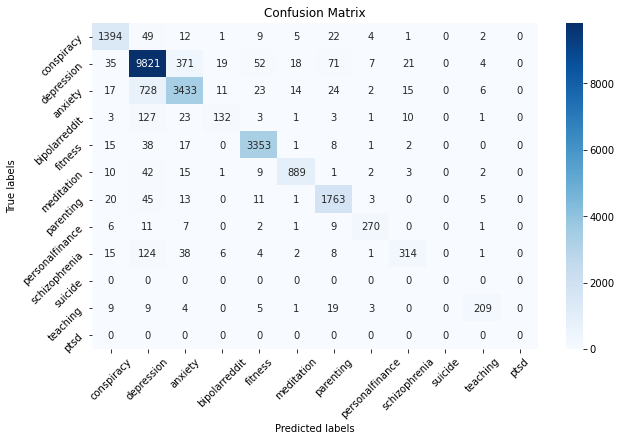

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels( labels,rotation=45); ax.set_yticklabels(labels,rotation=45);